# Detecting weather anomalies using ARMA processes
## Yngve Mardal Moe

In [2]:
%matplotlib notebook

import requests
import io
import itertools
from pprint import pprint
import datetime

import numpy as np
import pandas as pd 

import matplotlib.pyplot as plt
from matplotlib.collections import LineCollection
import matplotlib.dates as mdates

import statsmodels.api as sm

/home/yngve/anaconda3/lib/python3.6/site-packages/statsmodels/compat/pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas.core import datetools


## Let us prepare the dataset
Today we will analyse weather data from Ås; more specifically, we will analyse temperature data.

In [4]:
X = pd.read_csv('http://yngvem.no/weather.csv', index_col=0)
X.index = X.index.to_datetime()

y = X['Maksimum lufttemperatur i 2m hoyde (TX)']



# Cannot do random split on time series data
split_idx = y.index[len(y)//2]
y_train = y[:split_idx]
y_test = y[split_idx:]

/home/yngve/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:2: FutureWarning: to_datetime is deprecated. Use pd.to_datetime(...)
  


## Before we train, we plot our data

<IPython.core.display.Javascript object>


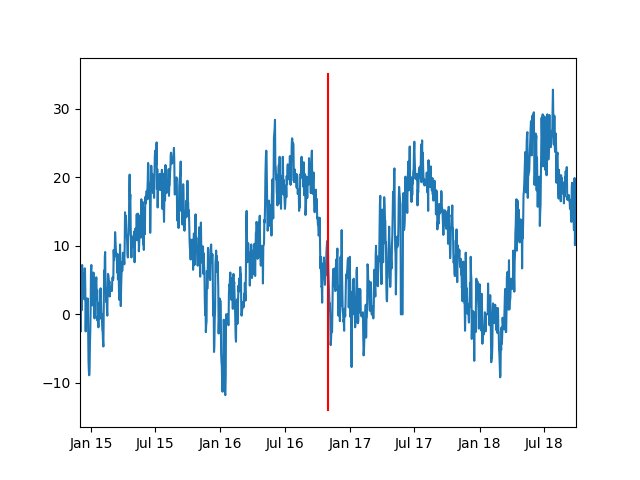

(735568.0, 736967.0)

In [66]:
fig = plt.figure()
sub = fig.add_subplot(111)

date_idx = mdates.date2num(y.index.to_pydatetime())
sub.plot(date_idx, y)
ylim = sub.get_ylim()
sub.plot(2*[mdates.date2num(split_idx)], ylim, 'r')

month_format = mdates.DateFormatter("%b %y")
sub.xaxis.set_major_formatter(month_format)
sub.xaxis.set_major_locator(mdates.MonthLocator(range(1,13,6)))
sub.set_xlim(date_idx[0], date_idx[-1])

## Let's find some outliers!

In [37]:
# We use a SARIMAX model, which is a more complicated version of ARMA,
# because the ARMA model doesn't support testing on new datasets
arma = sm.tsa.SARIMAX(y_train, order=(5, 0, 1))
results = arma.fit()

# Create model for testing and copy parameters
test_model = sm.tsa.SARIMAX(y_test, order=(5, 0, 1))
test_results = test_model.smooth(results.params)

In [47]:
test_prediction = test_results.predict()
test_error = test_prediction - y_test
MAE = np.median(np.abs(test_error))

print(f'The test median absolute error is {MAE}')

# We say that the outliers have an error more than two times the MAE
outliers = np.abs(test_error) > 3*MAE

The test median absolute error is 1.6368216938121645


<IPython.core.display.Javascript object>


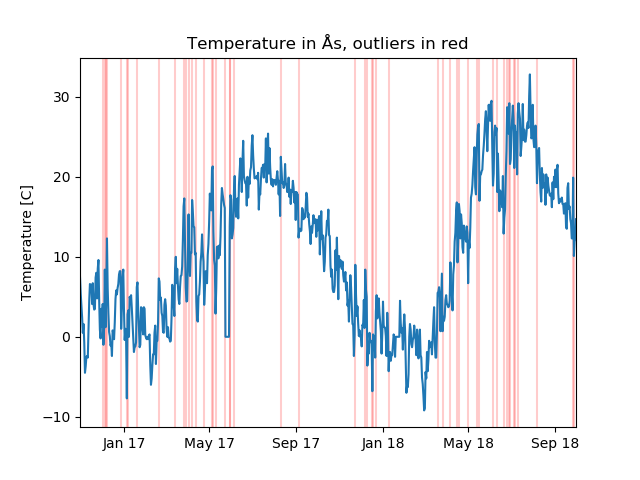

In [48]:
%matplotlib notebook

fig = plt.figure()
sub = plt.subplot()


date_index = mdates.date2num(y_test.index.to_pydatetime())
sub.plot(date_index, y_test)

outlier_dates = outliers.index[outliers]
col = [((mdates.date2num(date), -40), (mdates.date2num(date), 40)) for date in outlier_dates]
sub.add_collection(LineCollection(col, color=(1,0,0,0.2)))

# Make x-axis dates
month_format = mdates.DateFormatter("%b %y")
sub.xaxis.set_major_formatter(month_format)
sub.xaxis.set_major_locator(mdates.MonthLocator(range(1,13,4)))
sub.set_xlim(date_index[0], date_index[-1])

sub.set_title('Temperature in Ås, outliers in red')
sub.set_ylabel('Temperature [C]')